# Knn in Amazon Fine Food Reviews Analysis -40 K datapoints

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# Objective :-

Applied K-Nearest Neighbour on Different Featurization of Data  BOW, tfidf, Avg-Word2Vec and tf-idf-Word2Vec and check the performace meauserment for evaluate the accuracy of a classification 
1. Sort the data using time based
2. Take random sample data if we donot have that much RAM.
3. Use 10-fold cross validation method on train and cross_vaidation dataset .
4. For Optimal K find the accuracy in test dataset in each technique(BOW,TFIDF,Avg w2v,Tfidf-w2v)

In [1]:
import os

In [2]:
os.getcwd()

'C:\\Users\\Nicky\\Desktop\\my work\\K_NN'

In [4]:
#Importing the nessary library for this assignement .
import numpy as np
import pandas as pd
import sqlite3 as sql
from time import time
import pickle
import random
import gensim
import warnings
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
warnings.filterwarnings("ignore")

#Peforemance measurment techniques
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# confusion_matrix

Compute confusion matrix to evaluate the accuracy of a classification

By definition a confusion matrix C is such that C_{i, j} is equal to the number of observations known to be in group i but predicted to be in group j.

Thus in binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.

# precision_score

Compute the precision

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0

# Recall_score

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

# f1_score

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)
In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

# Serializing and De-serialzing of data

In [5]:
#Functions to save objects for later use and retireve it
import pickle
def export(obj,filename):
    pickle.dump(obj,open(filename+".dmp","wb"))
def import1(filename):
    temp = pickle.load(open(filename+".dmp","rb"))
    return temp

# Loading the cleaned data

In [6]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
food1 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
food1.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'june saw charm group rose begin droop pep ch...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
2,150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
3,150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,positive,1210809600,A classic,Get the movie or sound track and sing along wi...,b'get movi sound track sing along carol king g...
4,150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,b'entertain rhyme catchi illustr imagin fit ri...


In [7]:
#help(food1.sample)
food1_sample=food1.sample(n=40000) #Taking 40k random sample from hole dataset
food1_sample.sort_values('Time',inplace=True)
food1_sample.head(5)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
272,374381,374382,B00004CI84,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,positive,1014681600,...,"It was on the other night, and, having been a ...",b'night big fan cartoon shown decid watch also...
1082,479722,479723,B00005U2FA,A3TO9GEQEGKFDC,"N. Smith ""emerald999""",35,35,positive,1020211200,I love this thing,The wine saver is great in so many ways. Obvio...,b'wine saver great mani way obvious wonder abl...
3308,323602,323603,B0000CNU5A,A2WNWOJDL0A81,Jonathan Sprenke,1,2,positive,1065398400,mmmmmm salty,This product reminds me of a thousand lunches ...,b'product remind thousand lunch chicken teriya...
6318,11990,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,positive,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,b'chatchi favorit afternoon treat becam myster...
2369,30627,30628,B00008RCMI,A3AKWA5CWSKOOH,"Ilaxi S. Patel ""Editor, kidsfreesouls.com & A...",0,0,positive,1068076800,Refreshing Mouth Freshner!,A tennis player hubby of mine got this pack on...,b'tenni player hubbi mine got pack rack opel c...


In [8]:
food1_sample.groupby('Score').count()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
Score,,,,,,,,,,,
negative,5774,5774,5774,5774,5774,5774,5774,5774,5774,5774,5774
positive,34226,34226,34226,34226,34226,34226,34226,34226,34226,34226,34226


In [9]:
#Save the sample file in destop for fruther use .
export(food1_sample,'food1_sample')

#here we can able to see the 'Score/Lable' is in the word format , but after converting word in vector it will not help to us.
so we are convering the score in to numerical format .
e.i :-    positive =1
      and negative =0

In [10]:
food1_sample=import1('food1_sample')

In [11]:
def label(x):
    if x == "positive":
        return 1
    else:
        return 0
food1_sample["Score"] = food1_sample["Score"].map(label) #Map all the scores as the function polarity i.e. positive or negative

export(food1_sample,'food1_sample')

food1_sample.groupby('Score').head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
272,374381,374382,B00004CI84,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,1,1014681600,...,"It was on the other night, and, having been a ...",b'night big fan cartoon shown decid watch also...
1082,479722,479723,B00005U2FA,A3TO9GEQEGKFDC,"N. Smith ""emerald999""",35,35,1,1020211200,I love this thing,The wine saver is great in so many ways. Obvio...,b'wine saver great mani way obvious wonder abl...
3308,323602,323603,B0000CNU5A,A2WNWOJDL0A81,Jonathan Sprenke,1,2,1,1065398400,mmmmmm salty,This product reminds me of a thousand lunches ...,b'product remind thousand lunch chicken teriya...
5103,286452,286453,B0000DJ7WI,A375QRG43POEW6,dndnd,23,25,0,1069977600,Stay Away...,This product ships in great packaging and it l...,b'product ship great packag look good tast hor...
5551,170814,170815,B0000EIEWO,A3UU7SZXSZ2ZSB,David J. Dodson,9,12,0,1094688000,Good pears... bad service,I recently placed an order from this company a...,b'recent place order compani disappoint paid e...
1086,479726,479727,B00005U2FA,A1XDNOI4ZJM9AO,Jim,14,14,0,1101340800,Failed after 100,The Concerto worked well for about the first 5...,b'concerto work well first bottl seiz requir l...


# Bag of Words (BoW)

1. The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). Also known as the vector space model. In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The bag-of-words model has also been used for computer vision.
​
2. The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier.
​
3. An early reference to "bag of words" in a linguistic context can be found in Zellig Harris's 1954 article on Distributional Structure

Example implementation
The following models a text document using bag-of-words. Here are two simple text documents:

(1) John likes to watch movies. Mary likes movies too.
(2) John also likes to watch football games.
Based on these two text documents, a list constructed as follows for each document:

"John","likes","to","watch","movies","Mary","likes","movies","too"

"John","also","likes","to","watch","football","games"
Representing each bag-of-words as a JSON object, and attributing to the respective Javascript variable:

BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};
BoW2 = {"John":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
Each key is the word, and each value is the number of occurrences of that word in the given text document.

The order of elements is free, so, for example {"too":1,"Mary":1,"movies":2,"John":1,"watch":1,"likes":2,"to":1} is also BoW1. It is also what we expect from a strict JSON object representation.

Note: if another document is like a union of these two,

(3) John likes to watch movies. Mary likes movies too. John also likes to watch football games.
its Javascript representation will be:

BoW3 = {"John":2,"likes":3,"to":2,"watch":2,"movies":2,"Mary":1,"too":1,"also":1,"football":1,"games":1};
So, as we see in the bag algebra, the "union" of two documents in the bags-of-words representation is, formally, the disjoint union, summing the multiplicities of each element. 
{\displaystyle BoW3=BoW1\biguplus BoW2} {\displaystyle BoW3=BoW1\biguplus BoW2}.

In [6]:
food1_sample=import1('food1_sample') #load the data from deserilazing

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1_sample['CleanedText'].values,food1_sample['Score'].values,test_size=0.3,random_state=0)
print(X_train[0])
print('*************************************')
print(y_train[0])
#Text -> bi gram Vectors
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)      #fit the train data 
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)           #Only trasform the data as we are going to test the data in terms for predicting the correct class label
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

b'onion nice larg crispi howev sweeter anticip person prefer savori onion maritini mean disappoint flavor love larg prefer cocktail onion littl sweet side fantast purchas onion receiv white brown packag well'
*************************************
1
Train Data Size:  (28000, 512738)
Test Data Size:  (12000, 512738)


# Simple Cross Validation

In [14]:
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    



CV accuracy for k = 1 is 81%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 86%

CV accuracy for k = 11 is 86%

CV accuracy for k = 13 is 86%

CV accuracy for k = 15 is 86%

CV accuracy for k = 17 is 86%

CV accuracy for k = 19 is 86%

CV accuracy for k = 21 is 87%

CV accuracy for k = 23 is 86%

CV accuracy for k = 25 is 86%

CV accuracy for k = 27 is 86%

CV accuracy for k = 29 is 86%


Here we can able to see for knn 21 we are get accuracy of 87% in simple cross validation .
Let us test the knn in Test dataset and check what is the accuracy lavel

In [16]:
knn = KNeighborsClassifier(21)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 21 is %d%%' % (acc))


****Test accuracy for k = 21 is 86%


# 10 fold cross validation On Bag of Words:-

# Using brute-force Alogorithm :-


The optimal number of neighbors is 13.


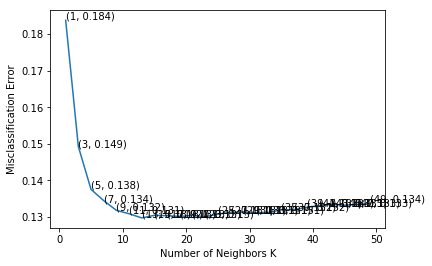

the misclassification error of train-dataset for each k value is :  [0.1837 0.1492 0.1376 0.1345 0.1319 0.1309 0.1298 0.1305 0.1304 0.1302
 0.1305 0.1301 0.1308 0.1313 0.1314 0.1312 0.1313 0.132  0.132  0.1326
 0.1331 0.1335 0.1332 0.1334 0.1338]
Wall time: 16min 55s


In [17]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error of train-dataset for each k value is : ", np.round(MSE,4))

In [18]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = [1 - acc/100]
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))



The accuracy of the knn classifier for k = 13 is 86.708333%

The misclassification error of test-dataset is [0.1329]


Accuracy on test set: 86.708%
Precision on test set: 0.873
Recall on test set: 0.988
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



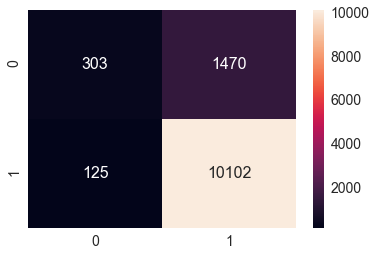

In [24]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Using KDTree Alogorithm


The optimal number of neighbors is 13.


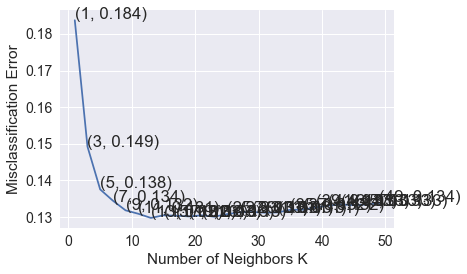

the misclassification error of train-dataset for each k value is :  [0.1837 0.1492 0.1376 0.1345 0.1319 0.1309 0.1298 0.1305 0.1304 0.1302
 0.1305 0.1301 0.1308 0.1313 0.1314 0.1312 0.1313 0.132  0.132  0.1326
 0.1331 0.1335 0.1332 0.1334 0.1338]
Wall time: 16min 54s


In [23]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error of train-dataset for each k value is : ", np.round(MSE,4))

In [25]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 13 is 86.708333%

The misclassification error of test-dataset is 0.1329


Accuracy on test set: 86.708%
Precision on test set: 0.873
Recall on test set: 0.988
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



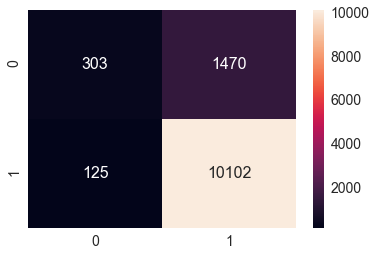

In [26]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TF-IDF :-

1. In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf.[2]

2. Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

3. One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

# Term frequency

Suppose we have a set of English text documents and wish to rank which document is most relevant to the query, "the brown cow". A simple way to start out is by eliminating documents that do not contain all three words "the", "brown", and "cow", but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, in the case where the length of documents varies greatly, adjustments are often made (see definition below). The first form of term weighting is due to Hans Peter Luhn (1957) which may be summarized as:

The weight of a term that occurs in a document is simply proportional to the term frequency.[3]

# Inverse document frequency

Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "brown" and "cow". The term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "brown" and "cow". Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

Karen Spärck Jones (1972) conceived a statistical interpretation of term specificity called Inverse Document Frequency (idf), which became a cornerstone of term weighting:

The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.[4]

In [27]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1_sample['CleanedText'].values,food1_sample['Score'].values,test_size=0.3,random_state=30)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalizing tfidf train Data
X_train = preprocessing.normalize(X_train)
print(" TF-IDF Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize tfidf train Data
X_test = preprocessing.normalize(X_test)
print("TF-IDF Test Data Size: ",X_test.shape)

 TF-IDF Train Data Size:  (28000, 514058)
TF-IDF Test Data Size:  (12000, 514058)
Wall time: 7.25 s


# 10 fold cross validation On TF-IDF:-

# Using brute-force Alogorithm :-


The optimal number of neighbors is 11.


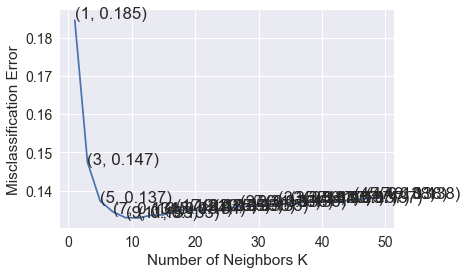

the misclassification error of train-dataset for each k value is :  [0.1845 0.1475 0.1373 0.1345 0.133  0.1329 0.1336 0.1337 0.1349 0.135
 0.1349 0.135  0.1355 0.1358 0.136  0.1362 0.1366 0.1365 0.137  0.1371
 0.1372 0.1373 0.1377 0.1379 0.1381]
Wall time: 17min 13s


In [28]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error of train-dataset for each k value is : ", np.round(MSE,4))

In [29]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 11 is 86.975000%

The misclassification error of test-dataset is 0.1302


Accuracy on test set: 86.975%
Precision on test set: 0.873
Recall on test set: 0.992
F1-Score on test set: 0.929
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



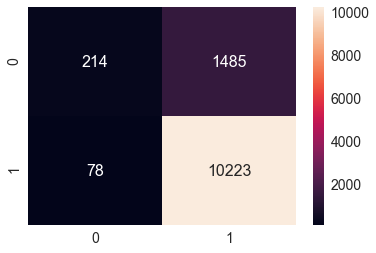

In [30]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Using KDTree Alogorithm :-


The optimal number of neighbors is 11.


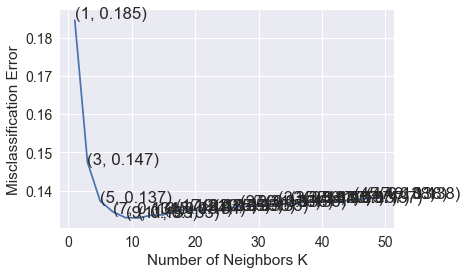

the misclassification error of train-dataset for each k value is :  [0.1845 0.1475 0.1373 0.1345 0.133  0.1329 0.1336 0.1337 0.1349 0.135
 0.1349 0.135  0.1355 0.1358 0.136  0.1362 0.1366 0.1365 0.137  0.1371
 0.1372 0.1373 0.1377 0.1379 0.1381]
Wall time: 17min 6s


In [31]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error of train-dataset for each k value is : ", np.round(MSE,4))

In [32]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 11 is 86.975000%

The misclassification error of test-dataset is 0.1302


Accuracy on test set: 86.975%
Precision on test set: 0.873
Recall on test set: 0.992
F1-Score on test set: 0.929
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



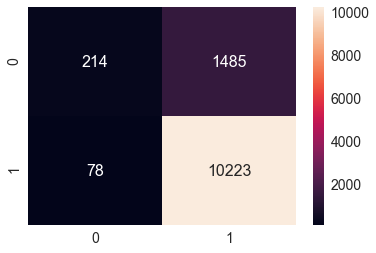

In [33]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Clean the text with no stem for avgw2v and tfidf-w2v model

In [7]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'into', 'll', 'any', 'through', 'itself', "won't", 'up', 'themselves', 'am', "should've", 'has', 'few', 've', 'all', 'out', 'there', "don't", "shouldn't", 'mustn', 'being', "you've", 'over', 'under', "hasn't", 'ain', 're', 'had', 'that', 'should', 's', 'during', 'why', "she's", 'from', 'o', 'hadn', 'is', "wasn't", 'most', "aren't", 'once', 'here', 'between', 'we', 'hers', 'whom', "couldn't", 'mightn', 'other', 'off', 'do', "needn't", 'because', 'i', 'more', 'my', 'if', 'with', "mustn't", 'after', 'were', 'those', 'needn', 'such', 'him', 'a', 'each', 'so', 'only', 'how', 'don', 'to', 'are', "hadn't", 'when', 'aren', 'down', "haven't", 'the', 'until', 'below', 'does', 'than', 'again', 'this', 'wasn', 'against', 'who', 'ma', 'd', "that'll", 'weren', 'haven', 'her', 'she', 'by', 'doesn', 'yours', 'did', "isn't", 'then', 'but', 'very', 'didn', 'own', "you're", 'some', 'while', 'y', 'couldn', 'about', "wouldn't", 'their', 'same', 'himself', 'was', 'nor', 'isn', "you'd", 'won', 'shouldn', 't

# Spliting the train and test data before running any model 

In [46]:
#for testing propose
#food1_sample=food1_sample.sample(n=5000)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(food1_sample['Text'],food1_sample['Score'],test_size=0.3,random_state=0)

In [9]:
X_train.head(1)

158951    These onions are nice, large and crispy - howe...
Name: Text, dtype: object

In [10]:
i=0
train_list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_list_of_sent.append(filtered_sentence)

In [11]:
print(len(train_list_of_sent))

28000


In [12]:
i=0
Test_list_of_sent=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    Test_list_of_sent.append(filtered_sentence)

In [13]:
print(len(Test_list_of_sent))

12000


# w2v model

Here we are using the google trained w2v model.
1. for using the w2v model , minimum 16 GB RAM required . so please carefull about it 

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [15]:
model.wv.similarity('woman', 'man')

0.76640123

In [16]:
model.wv.most_similar('woman')

[('man', 0.7664012312889099),
 ('girl', 0.7494641542434692),
 ('teenage_girl', 0.7336831092834473),
 ('teenager', 0.631708562374115),
 ('lady', 0.628878653049469),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.607630729675293),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975908041000366),
 ('Woman', 0.5770981311798096)]

# Avg w2v model

Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence

In [44]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in train_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

28000
300
Wall time: 23.1 s


In [45]:
train_sent_vectors = np.array(train_sent_vectors)

In [46]:
np.isnan(train_sent_vectors).any()

False

In [47]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
Test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in Test_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    Test_sent_vectors.append(sent_vec)
print(len(Test_sent_vectors))
print(len(Test_sent_vectors[0]))

12000
300
Wall time: 9.97 s


In [48]:
Test_sent_vectors = np.array(Test_sent_vectors)

In [49]:
np.isnan(Test_sent_vectors).any()

False

# 10 fold cross validation On Avg W2V:-

# Using brute-force Alogorithm :-


The optimal number of neighbors is 9.


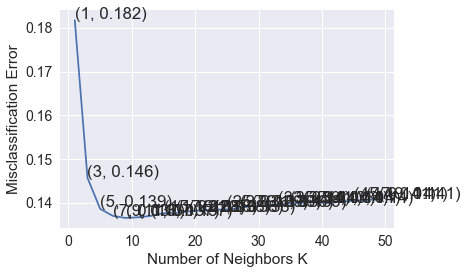

the misclassification error for each k value is :  [0.1818 0.1458 0.1386 0.137  0.1366 0.1367 0.137  0.1376 0.1377 0.1381
 0.1383 0.1384 0.1385 0.1389 0.1393 0.1393 0.1397 0.1399 0.14   0.1401
 0.14   0.1403 0.1405 0.1407 0.1408]
Wall time: 13min 22s


In [50]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, train_sent_vectors, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,4))

In [51]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(train_sent_vectors, y_train)

# predict the response
pred = knn_optimal.predict(Test_sent_vectors)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 9 is 86.083333%

The misclassification error of test-dataset is 0.1392


Accuracy on test set: 86.083%
Precision on test set: 0.865
Recall on test set: 0.992
F1-Score on test set: 0.924
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



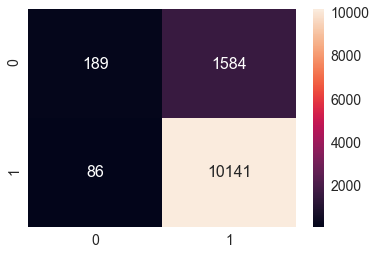

In [52]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Using kd-tree Alogorithm :-


The optimal number of neighbors is 9.


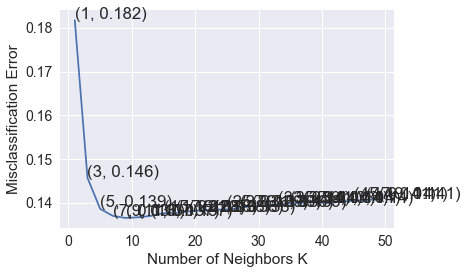

the misclassification error for each k value is :  [0.1818 0.1458 0.1386 0.137  0.1366 0.1367 0.137  0.1376 0.1377 0.1381
 0.1383 0.1384 0.1385 0.1389 0.1393 0.1393 0.1397 0.1399 0.14   0.1401
 0.14   0.1403 0.1405 0.1407 0.1408]
Wall time: 4h 5min 9s


In [53]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, train_sent_vectors, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,4))

In [54]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(train_sent_vectors, y_train)

# predict the response
pred = knn_optimal.predict(Test_sent_vectors)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 9 is 86.083333%

The misclassification error of test-dataset is 0.1392


Accuracy on test set: 86.083%
Precision on test set: 0.865
Recall on test set: 0.992
F1-Score on test set: 0.924
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



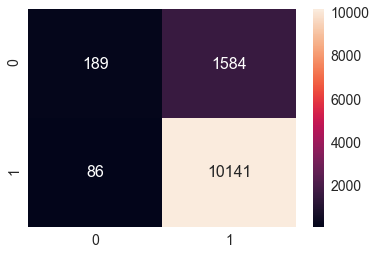

In [55]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TFIDF-W2V

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
tfidf = TfidfVectorizer(ngram_range=(1,1)) #Using bi-grams
tfidf_vec = tfidf.fit_transform(X_train)

In [18]:
print(tfidf_vec.shape)

(28000, 33812)


In [19]:
tfidf_feat = tfidf.get_feature_names()

In [20]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in train_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tfidf_vec[row, tfidf_feat.index(word)]
            #print()
            sent_vec += (vec * tfidf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1


Wall time: 25min 18s


In [21]:
train_tfidf_sent_vectors = np.array(train_tfidf_sent_vectors)

In [22]:
np.isnan(train_tfidf_sent_vectors).any()

False

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
tfidf = TfidfVectorizer(ngram_range=(1,1)) #Using bi-grams
tfidf_test_vec = tfidf.fit_transform(X_test)

In [24]:
tfidf_test_feat = tfidf.get_feature_names()

In [25]:
print(tfidf_test_vec.shape)

(12000, 22768)


In [26]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in Test_list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tfidf_test_vec[row, tfidf_test_feat.index(word)]
            #print()
            sent_vec += (vec * tfidf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

Wall time: 7min 21s


In [27]:
test_tfidf_sent_vectors = np.array(test_tfidf_sent_vectors)

In [28]:
np.isnan(test_tfidf_sent_vectors).any()

True

In [32]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='median')
test_tfidf_sent_vectors = mean_imputer.fit_transform(test_tfidf_sent_vectors)

In [33]:
np.isnan(test_tfidf_sent_vectors).any()

False

# 10 fold cross validation On TfIDF-W2v

# Using brute-force Alogorithm :-


The optimal number of neighbors is 9.


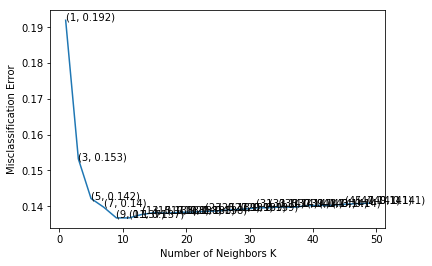

the misclassification error for each k value is :  [0.192  0.1532 0.1422 0.1398 0.1368 0.1368 0.1377 0.1382 0.1381 0.1383
 0.1384 0.1386 0.1387 0.139  0.1392 0.1395 0.1396 0.1398 0.1397 0.1401
 0.1403 0.1403 0.1406 0.1407 0.1409]
Wall time: 14min 34s


In [34]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, train_tfidf_sent_vectors, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,4))

In [35]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(train_tfidf_sent_vectors, y_train)

# predict the response
pred = knn_optimal.predict(test_tfidf_sent_vectors)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 9 is 85.633333%

The misclassification error of test-dataset is 0.1437


Accuracy on test set: 85.633%
Precision on test set: 0.862
Recall on test set: 0.990
F1-Score on test set: 0.922
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



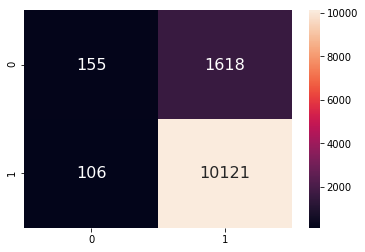

In [36]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Using kd-tree Alogorithm :-


The optimal number of neighbors is 9.


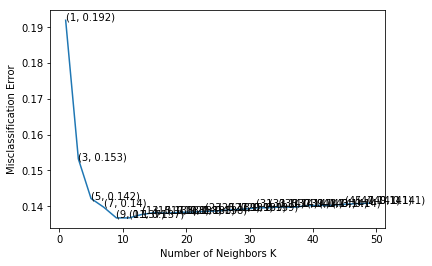

the misclassification error for each k value is :  [0.192  0.1532 0.1422 0.1398 0.1368 0.1368 0.1377 0.1382 0.1381 0.1383
 0.1384 0.1386 0.1387 0.139  0.1392 0.1395 0.1396 0.1398 0.1397 0.1401
 0.1403 0.1403 0.1406 0.1407 0.1409]
Wall time: 4h 5min 9s


In [37]:
%%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, train_tfidf_sent_vectors, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,4))

In [38]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(train_tfidf_sent_vectors, y_train)

# predict the response
pred = knn_optimal.predict(test_tfidf_sent_vectors)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
MSE = 1 - acc/100
print('\nThe misclassification error of test-dataset is', np.round(MSE,4))


The accuracy of the knn classifier for k = 9 is 85.633333%

The misclassification error of test-dataset is 0.1437


Accuracy on test set: 85.633%
Precision on test set: 0.862
Recall on test set: 0.990
F1-Score on test set: 0.922
Confusion Matrix of test set:
 [ [TN  FN]
 [FP TP] ]



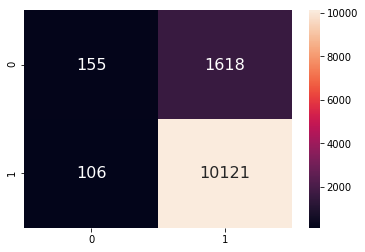

In [39]:
#Testing Accuracy on Test data
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FN]\n [FP TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Performance Table

In [42]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","hyper parameter", "Train eror","Test error","F1-Score"]

x.add_row(["BOW", 13, 0.1298, 0.1329,0.927])
x.add_row(["TF-IDF", 11, 0.1329, 0.1302,0.929])
x.add_row(["Avg w2v", 9, 0.1366, 0.1392,0.924])
x.add_row(["Tfidf-w2v", 9, 0.1368, 0.1437,0.922])

print(x)

+-----------+-----------------+------------+------------+----------+
|   Model   | hyper parameter | Train eror | Test error | F1-Score |
+-----------+-----------------+------------+------------+----------+
|    BOW    |        13       |   0.1298   |   0.1329   |  0.927   |
|   TF-IDF  |        11       |   0.1329   |   0.1302   |  0.929   |
|  Avg w2v  |        9        |   0.1366   |   0.1392   |  0.924   |
| Tfidf-w2v |        9        |   0.1368   |   0.1437   |  0.922   |
+-----------+-----------------+------------+------------+----------+


# Conclusions

1. Form above performance table we can able to see that among all the model TF-IDF has greater performance(f1-score=0.929 and testerror=0.1302).
2. It may differ if we go for more point as i use 40k datapoints i got the above result.
3. Both brute-force and kd-tree alog givng same result . But k-dtree is slow as compare to brtue-force